In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

from utils.dataloader import get_train_loaders, get_test_loaders
from utils.model import CustomVGG
from utils.helper import train, evaluate, predict_localize
from utils.constants import NEG_CLASS

c:\users\kyle\appdata\local\programs\python\python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parameters

In [2]:
batch_size = 40
target_train_accuracy = 0.98 # for early stopping of model training
test_size = 0.2 # for reduction of samples in test set
learning_rate = 0.0001
epochs = 10
class_weight = [1, 3] if NEG_CLASS == 1 else [3, 1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

heatmap_thres = 0.7

##  Load Training Data

In [3]:
data_folder = "data/"
subset_name = ["capsule", "hazelnut", "leather"] # list all objects for training
roots = []

for subset in subset_name:
    roots.append(os.path.join(data_folder, subset))

train_loader = get_train_loaders(
    roots=roots,
    batch_size=batch_size,
    random_state=42
)

Dataset loaded (training) data/capsule: N Images = 351, Percentage of defected images = 0.311
Dataset loaded (training) data/hazelnut: N Images = 501, Percentage of defected images = 0.140
Dataset loaded (training) data/leather: N Images = 369, Percentage of defected images = 0.249


# Model Training

In [4]:
model = CustomVGG()

class_weight = torch.tensor(class_weight).type(torch.FloatTensor).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weight)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
model = train(
    train_loader, model, optimizer, criterion, epochs, device, target_train_accuracy
)

Epoch 1:   0%|                                                                               | 0/30 [00:01<?, ?batch/s]c:\users\kyle\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch 1: 100%|██████████████████████████████████████████████████████████████████████| 30/30 [03:15<00:00,  6.52s/batch]


Loss = 0.5902, Accuracy = 0.6792


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████| 30/30 [03:14<00:00,  6.47s/batch]


Loss = 0.3641, Accuracy = 0.8025


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████| 30/30 [03:12<00:00,  6.41s/batch]


Loss = 0.2602, Accuracy = 0.8800


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████| 30/30 [03:11<00:00,  6.37s/batch]


Loss = 0.2012, Accuracy = 0.9292


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████| 30/30 [03:13<00:00,  6.44s/batch]


Loss = 0.1456, Accuracy = 0.9367


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████| 30/30 [03:12<00:00,  6.43s/batch]


Loss = 0.1473, Accuracy = 0.9433


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████| 30/30 [03:17<00:00,  6.57s/batch]


Loss = 0.1013, Accuracy = 0.9592


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████| 30/30 [03:15<00:00,  6.51s/batch]


Loss = 0.0961, Accuracy = 0.9667


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████| 30/30 [03:13<00:00,  6.46s/batch]


Loss = 0.1008, Accuracy = 0.9642


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████| 30/30 [03:14<00:00,  6.48s/batch]

Loss = 0.0613, Accuracy = 0.9792


# Loading Saved Weights

In [6]:
model_path = f"weights/{subset_name}_model.h5"
torch.save(model, model_path)
# model = torch.load(model_path, map_location=device)

##  Load Testing Data

In [10]:
data_folder = "data/"
subset_name = ["bottle", "pill", "wood"] # list all objects for training
roots = []

for subset in subset_name:
    roots.append(os.path.join(data_folder, subset))

test_loader = get_test_loaders(
    roots=roots,
    batch_size=batch_size,
    test_size=0.9,
    random_state=42
)

Dataset loaded (testing) data/bottle: N Images = 292, Percentage of defected images = 0.216
Dataset loaded (testing) data/pill: N Images = 434, Percentage of defected images = 0.325
Dataset loaded (testing) data/wood: N Images = 326, Percentage of defected images = 0.184


# Evaluation

c:\users\kyle\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


Accuracy: 0.6663
Balanced Accuracy: 0.7018



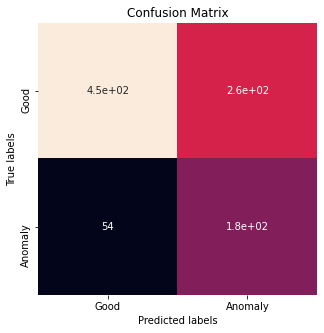

In [11]:
evaluate(model, test_loader, device)

# Visualization

c:\users\kyle\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


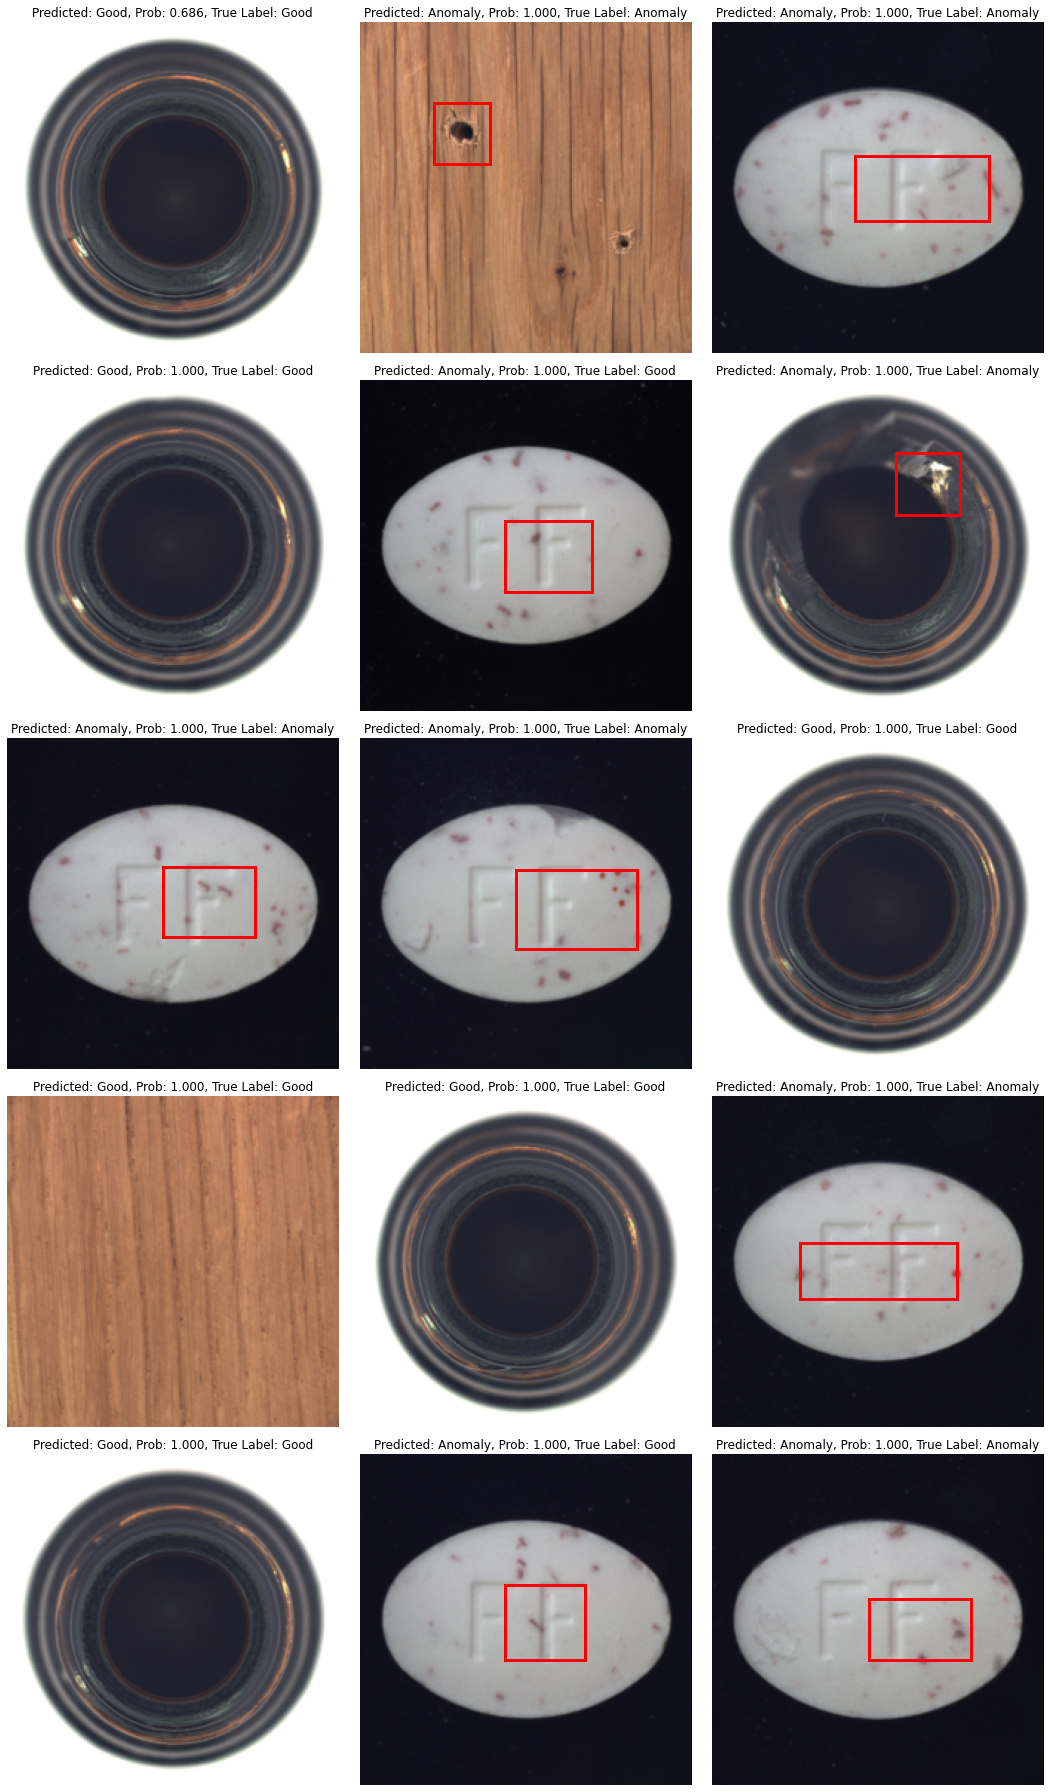

In [9]:
predict_localize(
    model, test_loader, device, thres=heatmap_thres, n_samples=15, show_heatmap=False
)